## Definitions

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pdb
idx = pd.IndexSlice

import matplotlib.colors

custom_colors = [tuple(list(matplotlib.colors.to_rgb(c)) + [alpha]) for c in ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'] for alpha in (.5,1)]   

## Parameters
### Share of group queues that will receive an intervention each year

In [2]:
intervention_shares = pd.Series({
    ('low','self_help'):.4,
    ('low','consulting'):.2,
    ('low','mop_payment'):.2,
    ('high','self_help'):.2,
    ('high','consulting'):.2,
    ('high','mop_payment'):.2
}).unstack()
intervention_shares

,consulting,mop_payment,self_help
high,0.2,0.2,0.2
low,0.2,0.2,0.4


### Share of intervened that will return to queue after receiving an intervention

In [3]:
relapse_rates = pd.Series({
    ('low','self_help'):.8,
    ('low','consulting'):.6,
    ('low','mop_payment'):.4,
    ('low','guaranteed'):.2,
    ('low','municipal'):.2,
    ('high','self_help'):.7,
    ('high','consulting'):.5,
    ('high','mop_payment'):.3,
    ('high','guaranteed'):.1,
    ('high','municipal'):.1
}).unstack()

relapse_rates

,consulting,guaranteed,mop_payment,municipal,self_help
high,0.5,0.1,0.3,0.1,0.7
low,0.6,0.2,0.4,0.2,0.8


### Number of hhs in housing emergency

In [4]:
hhs_inflow = pd.Series({
    ('low','current_level'):.65 * 50000,
    ('low','yearly_growth'):500,
    ('high','current_level'):.35 * 50000,
    ('high','yearly_growth'):500,
}).unstack(1)
hhs_inflow

,current_level,yearly_growth
high,17500.0,500.0
low,32500.0,500.0


In [5]:
years_of_support = pd.Series({
    'municipal':5,
    'guaranteed':2,
    'self_help':1,
    'mop_payment':1,
    'consulting':1
})
years_of_support

municipal      5
guaranteed     2
self_help      1
mop_payment    1
consulting     1
dtype: int64

In [6]:
intervention_costs = pd.Series({
    ('fixed','self_help'):0,
    ('fixed','consulting'):5000,
    ('fixed','mop_payment'):15000,
    ('fixed','guaranteed'):5000,
    ('fixed','municipal'):5000,
    ('variable','self_help'):0,
    ('variable','consulting'):0,
    ('variable','mop_payment'):0,
    ('variable','guaranteed'):25000,
    ('variable','municipal'):25000
}).unstack()
intervention_costs

,consulting,guaranteed,mop_payment,municipal,self_help
fixed,5000,5000,15000,5000,0
variable,0,25000,0,25000,0


In [7]:
DEFAULT_PARAMS = {
    'years':np.arange(20),
    'years_of_support':years_of_support,
    'intervention_costs':intervention_costs,
    'guaranteed_yearly_apartments':2500, # Konzervativní odhad 2500 - 1 byt na měsíc pro každé ORP; Divoký odhad 10 000 bytl,
    'municipal_apartments_today': 200000,
    'municipal_yearly_new_apartments': 1000,
    'municipal_existing_availability_rate': .015,
    'municipal_new_availability_rate': .3,
    'low_risk_to_high_risk_transfer_share':1-.33,
    'high_risk_to_low_risk_transfer_share':.33,
    'relapse_rates':relapse_rates,
    'intervention_shares':intervention_shares,
    'hhs_inflow':hhs_inflow
}

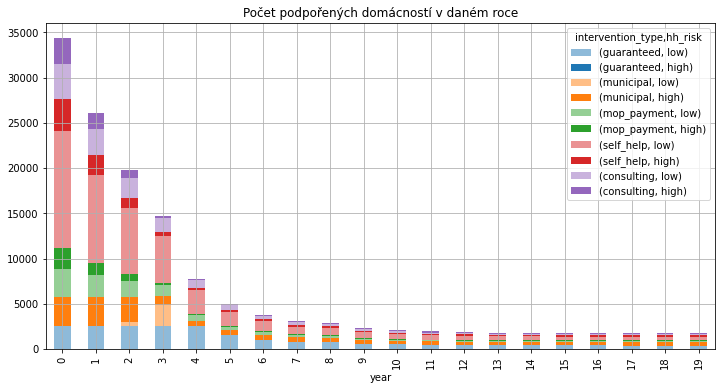

In [44]:
from main import generate_interventions
from supply import simulate_apartment_stock

apartments = simulate_apartment_stock(
    guaranteed_yearly_apartments=DEFAULT_PARAMS['guaranteed_yearly_apartments'],
    municipal_apartments_today=DEFAULT_PARAMS['municipal_apartments_today'],
    municipal_yearly_new_apartments=DEFAULT_PARAMS['municipal_yearly_new_apartments'],
    municipal_existing_availability_rate=DEFAULT_PARAMS['municipal_existing_availability_rate'],
    municipal_new_availability_rate=DEFAULT_PARAMS['municipal_new_availability_rate'],
    years=DEFAULT_PARAMS['years']
)

interventions, hhs, returnees = generate_interventions(
    apartments = apartments,
    relapse_rates = DEFAULT_PARAMS['relapse_rates'],
    intervention_shares = DEFAULT_PARAMS['intervention_shares'],
    low_risk_to_high_risk_transfer_share = DEFAULT_PARAMS['low_risk_to_high_risk_transfer_share'],
    high_risk_to_low_risk_transfer_share = DEFAULT_PARAMS['high_risk_to_low_risk_transfer_share'],
    hhs_inflow = DEFAULT_PARAMS['hhs_inflow'],
    years_of_support = DEFAULT_PARAMS['years_of_support'],
    years = DEFAULT_PARAMS['years']
)

interventions.unstack(['intervention_type','hh_risk']).plot.bar(stacked=True, grid=True, figsize=(12,6),title='Počet podpořených domácností v daném roce',color=custom_colors);

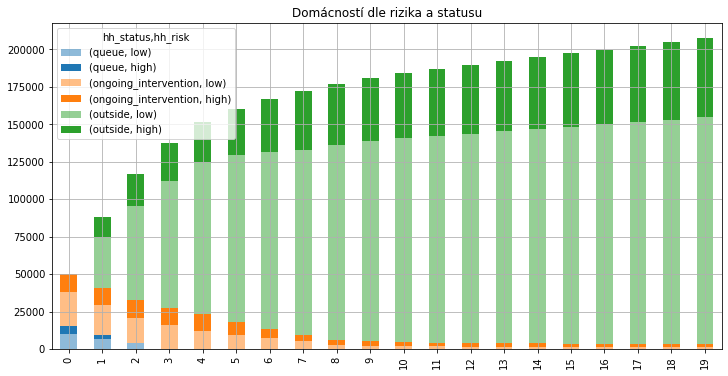

In [45]:
hhs.plot.bar(stacked=True, grid=True, figsize=(12,6),title='Domácností dle rizika a statusu',color=custom_colors);

 ## Nabídka - byty v systému

* Nabídka simuluje počet bytů v systému, které budou k dispozici pro domácnosti v bytové nouzi. Model simuluje zvlášť byty ze soukromého sektoru a byty, které jsou ve správě místních samospráv
* Nastavení modelu vede k  (téměř) lineárnímu vkladu bytů do systému. Defaultní nastavení vede k tempu 5000 soukromých a pomalu rostoucích cca 3500 - 4000 městských bytů v systému ročně.

### Garantované byty
* TODO přepsat všude na garantované
* Nabídka soukromých bytů závisí primárně na konkurenceschopnosti podmínek pro pronajímatale a úspěšnosti komunikace
* Jejich počet proto je modelován jediným parametrem: `private_yearly_apartments`.
* Z komunikace s Romanem Matouškem proto vzešel návrh zvažovat tři scénáře: 
    - *Konzervativní* - 2 500 bytů ročně, tj. 10 bytů na ORP, tedy méně než 1 byt na ORP za měsíc
    - *Střední* - 5 000 bytů ročně
    - *Rozsáhlý* - 10 000 bytů ročně
* Pokud není řečeno jinak je použit *střední scénář* 

### Obecní byty
* Již dnes existuje cca 200 000 bytů - `municipal_apartments_today`
* Z již existujících bytů se každoročně 1,5 % uvolní do systému sociálního bydlení - `municipal_existing_availability_rate`
* I v budoucnu budou stavět nové městské byty - konzervativně předpokládáme 1000 bytů ročně - `municipal_yearly_new_apartments`
* Z nových bytů předpokládáme, že by do systému výrazně větší část - klidně 50 % - `municipal_new_availability_rate`


## Poptávka - lidé v bytové nouzi

* Také poptávka je modelována 2 druhy domácností
* Model prefenčně umísťuje *ekonomicky aktivní* domácnosti do *soukromých* bytů a *ekonomicky neaktivní* domácnosti do *obecních* bytů 
* Oba druhy domácností mají v čase lineární trend



### Ekonomicky aktivní 

* Dnešní počet ekonomicky aktivních domácností v bytové nouzi je 43 250 - `active_current_hh_in_need`. Vychází ze Zprávy o vyloučení z bydlení 2021
* Předpokládáme každoroční propad dalších 2000 domácností do bytové nouze -  `active_yearly_new_hh`.

### Ekonomicky neaktivní
* Dnešní počet ekonomicky neaktivních domácností v bytové nouzi je 60 000 - `inactive_current_hh_in_need`. Myslím, že na radu Romana Matouška.
* Předpokládáme každoroční propad dalších 500 domácností do bytové nouze -  `inactive_yearly_new_hh`.

## Přemýšlení s Lucií - Nová struktura domácností
- dělit domácnosti na méně a více rizikové 
- dle souběhu a typu rizik

- typy rizik: 
    - neplnění finančních povinností - primárně řešeno dávkama - příspěvkem na bydlení
    - kompetence v bydlení - společenské schopnosti, finanční gramotnost - potřebují asistenci v bydlení
    - riziko vstupu na trh bydlení - diskriminace
    
### Mé

###

## Vypořádání modelu
* Vypořádání probíhá každoročně
* V průběh vypořádání se v modelu rozdělují tzv. jednorázové podpory (*soft interventions*) a *přidělují se byty*. Zároveň určitá část domácností situaci nezvládne i přes státní podporu - role tzv. *navrátilců* (`returnees`).

### Jednorázové podpory
* Určitá část domácností v daném roce čekající na podporu - `soft_intervention_share` - dostane jednorázovou podporu a hned v dalším roce vystupují ze systému.
* Nicméně další část těchto domácností - `soft_relapse_rate` se hned další rok se dostane do systému znovu.

### Přiiřazování bytů
* Probíhá pro každou skupinu bytů i domácností zvlášť v předem daném pořadí
* Pro každou skupinu se určí kolik domácností podporu žádá a kolik bytů má daná skupina k dispozici. Všechny byty, které jsou k dispozici a po kterých je poptávka se takto přidělí.
* Přiřazování probíhá v následujícím pořadí, přičemž první dva body se vzájemně neruší
    1. Ekonomicky aktivní do soukromých bytů 
    2. Ekonomicky nekativní do obecních bytů
    3. Ekonomicky neaktivní do soukromých bytů
    4. Ekonomicky aktivní do obecních bytů
* Podpora v bydlení trvá omezenou dobu - `private_years_of_support` a `municipal_years_of_support`
* Nicméně další část těchto domácností - `soft_relapse_rate` se hned o nějakou dobu později - `apartment_returnee_delay` dostane do systému znovu.



### Lucie

Domácnosti: 
* Ohrožení BN
* Low Risk
* High Risk

Fronta:
- LR + HR + OBN


Intervence má vždy parametry:
 * zvlášť pro všechny typy domácností
 * podíl eligible
 * returnee rate
 
 
U přidělování bytů everything goes. 
1. Self-help
2. Consulting - vždy celá fronta (každý rok?) 
3. Consulting-help
4. Intervence MOPka
5. Prioritní assignment bytů
    a.LR -> Garantované byty - returnees by se mohli stát high-risk. Left the system = Návrat do systému.
    b. HR -> Obecní byty - samostatná škatulka returnees = odpad. 
6. Sekundární assignemnt bytů
    a.LR -> Obecní byty
    b. HR -> Garantované (chceme to vůbec dělat???)    

In [ ]:
interventions.unstack(['intervention_type','hh_risk']).plot.bar(stacked=True, grid=True, figsize=(12,6),title='Počet podpořených domácností v daném roce',color=custom_colors);

In [ ]:
hhs.loc[idx[:,'current_intervention',:]].unstack('hh_risk')#.plot.bar()

In [ ]:
interventions.unstack(['hh_type','intervention_type']).sort_index(axis=1)

In [ ]:
returnees.unstack(['intervention_type','hh_type']).plot.bar(stacked=True, grid=True, figsize=(12,6),title='Počet navrátilců v daném roce',color=custom_colors,legend=False);

## Simulace alternativ
* V následující sekci ukazuje možnosti modelu - zejména možnost posouvání jednotlivých parametrů a jejich vliv na výsledek
* Grafy níže rozdělují celkový počet domácností, které kdy do daného roku vstoupili do bytové nouze (kumulativně) do následujících kategorií:
    - `in_queue`  čekající na jakoukoliv podporu
    - `recent_soft` - soft intervence v tomto roce 
    - `recent_self_help` - svépomoci v tomto roce 
    - `currently_in_municipal` - umístěni do obecního bytu - 
    - `currently_in_private` - umístěni do soukromého bytu - 
    - `outside` - vystoupivší ze systému.
* Interpretaci tohoto grafu komplikují *relapses* - tedy podpořené domácnosti, které se ale přesto později do systému vrátili. V tuto chvíli jsou jednak v kategorii `outside`, ale ve stejný moment vstupují zároven zpět do systému do kategorie `in_queue`.

### Schopnost získat byty

In [ ]:
from plotting import plot_single_param_variation, plot_two_param_variation

plot_single_param_variation(
    varied_param='private_yearly_apartments',
    variations=[1000,2500,5000], 
    title_blueprint='{private_yearly_apartments} soukromých bytů ročně', 
    suptitle='Domácnosti v bytové nouzi procházející systémem dle počtu soukromých bytů ročně',
    default_params = DEFAULT_PARAMS
);

In [ ]:
plot_two_param_variation(
    first_param='private_yearly_apartments',
    first_variations=[1000,2500,5000],
    second_param='municipal_yearly_new_apartments',
    second_variations=[0,1000,2000], 
    title_blueprint='{private_yearly_apartments} soukromých \n {municipal_yearly_new_apartments} městských', 
    suptitle='Domácnosti v bytové nouzi procházející systémem dle počtu soukromých a městských bytů ročně',
    default_params=DEFAULT_PARAMS
);

### Schopnost získat obecní byty do systému

In [ ]:
plot_single_param_variation(
    varied_param='municipal_existing_availability_rate', 
    variations=[0.01,0.025,0.05], 
    title_blueprint='{municipal_existing_availability_rate}% ze všech obecních bytů do systému ročně',
    suptitle='Domácnosti v bytové nouzi procházející systémem dle schopnosti využívat existujících obecních bytů',
    default_params=DEFAULT_PARAMS
);

### Schopnost stavět nové obecní byty

In [ ]:
plot_single_param_variation(
    varied_param='municipal_yearly_new_apartments', 
    variations=[0, 1000, 5000], 
    title_blueprint='{municipal_yearly_new_apartments} nových obecních bytů ročně',
    suptitle='Domácnosti v bytové nouzi procházející systémem dle schopnosti stavět nové obecní byty',
    default_params=DEFAULT_PARAMS
);

### Role jednorázové podpory
- například dávky mimořádné okamžité pomoci

In [ ]:
plot_single_param_variation(
    varied_param='soft_intervention_share', 
    variations=[.0, .015, .02,.05], 
    title_blueprint='{soft_intervention_share}% čekajících domácností dostane jednorázovou podporu',
    suptitle='Domácnosti v bytové nouzi procházející systémem dle míry čerpání jednorázové podpory',
    default_params=DEFAULT_PARAMS
);

### Role "svépomoci"

In [ ]:
plot_two_param_variation(
    first_param='active_self_help_share',
    first_variations=[.05,.1,.15],
    second_param='inactive_self_help_share',
    second_variations=[.05,.1,.15], 
    title_blueprint='{active_self_help_share}% aktivních \n {inactive_self_help_share}% neaktivních', 
    suptitle='Domácnosti v bytové nouzi procházející systémem dle schopnosti si "poradit sami"',
    default_params=DEFAULT_PARAMS
);